In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gaze_prf.utils.analyze_mcmc import check_prediction

order = ["V1", "V2", "V3", "V3AB", "LO", "VO", "hMT+", "iIPS", "sIPS", "sPCS", "iPCS", "mPCS"]

/tank/gdehol/miniconda3/envs/tf-cpu/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
df = pd.read_parquet('/tank/shared/2021/visual/pRFgazeMod/derivatives/barfits/mcmc_summaries_n_voxels-250.parquet')


/tank/gdehol/miniconda3/envs/tf-cpu/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
index_order = df.index.names

df = df.reset_index('task')
df['task'] = df['task'].map({'AttendFix':'attend-fix', 'AttendStim':'attend-bar'})
df = df.set_index(['task'], append=True).reorder_levels(index_order)

In [4]:
pred = df.groupby(['subject', 'session', 'task', 'gaze', 'roi']).apply(check_prediction)

In [5]:
import pingouin

r_map = df.groupby(['subject', 'session', 'task', 'gaze', 'parameter', 'roi']).apply(lambda d: pingouin.corr(d['value'], d['map']))
r_exp = df.groupby(['subject', 'session', 'task', 'gaze', 'parameter', 'roi']).apply(lambda d: pingouin.corr(d['value'], d['estimate']))
r_error = df.groupby(['subject', 'session', 'task', 'gaze', 'parameter', 'roi']).apply(lambda d: pingouin.corr(d['abs(error)'], d['std']))

/tank/gdehol/miniconda3/envs/tf-cpu/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [6]:
r_exp.to_csv('/tank/shared/2021/visual/pRFgazeMod/derivatives/barfits/predictive_accuracy_n_voxels-250.tsv', sep='\t')

In [7]:
import seaborn as sns

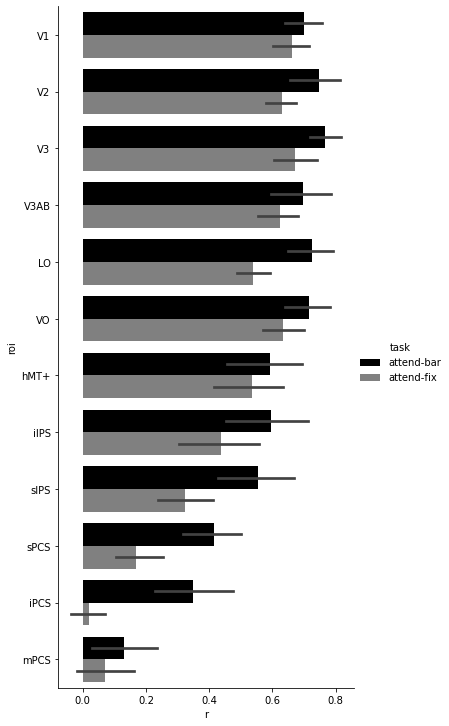

In [8]:
sns.catplot(x='r', y='roi', hue='task', data=r_exp.xs('x', 0, 'parameter').groupby(['subject', 'roi', 'task']).mean().reset_index(), 
            palette=['black', 'gray'], kind='bar',
           order=order, aspect=1/2., height=10)

# plt.suptitle('Correlation real and estimated x-position bar')

/tank/gdehol/miniconda3/envs/tf-cpu/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, hue. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-0.2, 0.77286321724283)

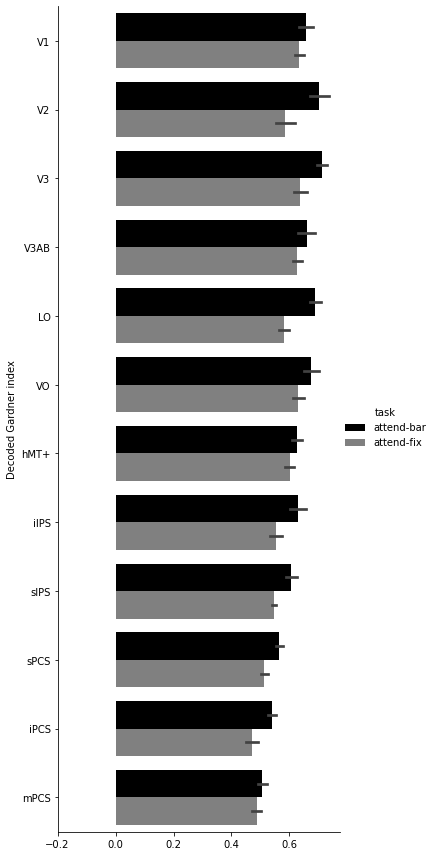

In [9]:
tmp = df.xs('x', 0, 'parameter').reset_index('gaze')

tmp = tmp.loc[tmp['gaze'] != 'Center']
tmp.loc[tmp['gaze'] == 'Left', 'spatiotopic_coordinate'] = tmp.loc[tmp['gaze'] == 'Left', 'value'] - 4
tmp.loc[tmp['gaze'] == 'Right', 'spatiotopic_coordinate'] = tmp.loc[tmp['gaze'] == 'Right', 'value'] + 4

tmp['error_retino'] = tmp['estimate'] - tmp['value'] 
tmp['error_spatio'] = tmp['estimate'] - tmp['spatiotopic_coordinate']


ss_spatio = tmp.groupby(['subject', 'roi', 'task']).apply(lambda d: (d['error_spatio']**2).sum())
ss_retino = tmp.groupby(['subject', 'roi', 'task']).apply(lambda d: (d['error_retino']**2).sum())

gardner = ((ss_spatio - ss_retino) / (ss_spatio + ss_retino)).to_frame('gardner')

fac = sns.catplot('gardner', 'roi', 'task', data=gardner.reset_index(), kind='bar', order=order, aspect=1./2.5, ci=67,
                  height=12,
           palette=['black', 'gray'])

fac.set(ylabel='Decoded Gardner index', xlabel='')

plt.xlim(-.2, None)

In [11]:
gardner.to_csv('/tank/shared/2021/visual/pRFgazeMod/derivatives/barfits/gardner_n_voxels-250.tsv', sep='\t')